Description:  This script produces Figure 7 (equivalent reflectivity factor contours for Edmond-Carney storm at surface and mid-levels)

In [32]:
import glob
import os
import sys
from copy import deepcopy
from datetime import datetime
from operator import itemgetter

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyart
import scipy.ndimage as ndimage
import xarray as xr
from matplotlib.pyplot import cm


from may19_2013_obs_analysis.wsr88d_parsing import plot_point
from may19_2013_obs_analysis.utils import ray_height

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["font.size"] = 13

In [33]:
# list out all radar files
files_radar = sorted(glob.glob(os.path.expanduser("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/*V06")))
files_az_shear = sorted(glob.glob(os.path.expanduser("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/az_shear/*.nc")))

# select only the ones needed for Figure 7
files_rad_interest = list(
    itemgetter(6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_radar)
)

files_az_shear_interest = list(
    itemgetter(6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_az_shear)
)

In [34]:
# List of all elevation angles (sweep angles) that have a visible WER/BWER in PPI plot
# This list will be used while iterating through radar files

mdlvl_swps = [11, 11, 12, 12, 12, 13, 12, 12, 12, 10, 10, 10]
mdlvl_swps = np.reshape(mdlvl_swps, (4, 3))

In [36]:
# despeckle radar reflectivity field and mask reflectivity values lower than 20 dBZ

all_radars = []

for i in range(len(files_rad_interest)):

    radar = pyart.io.read(files_rad_interest[i])
    filter = pyart.filters.GateFilter(radar)
    filter.exclude_below("reflectivity", 20)
    filter = pyart.correct.despeckle_field(
        radar, "reflectivity", size=30, gatefilter=filter
    )
    corrected_reflectivity = deepcopy(radar.fields["reflectivity"])
    corrected_reflectivity["data"] = np.ma.masked_where(
        filter.gate_excluded, corrected_reflectivity["data"]
    )
    radar.add_field(
        "corrected_reflectivity", corrected_reflectivity, replace_existing=True
    )

    all_radars.append(radar)

In [37]:
# manually identified xy locs of approximate BWER location visible in reflectivity plots above 

x_pts = [-45,-45,-40,-35,-35,-35,-15,-10,-10,15,15,20]*np.array([1000])
y_pts = [30,30,35,35,40,35,35,40,40,45,50,60]*np.array([1000])

f = lambda x,y: np.sqrt(x**2 + y**2)

ranges = list(map(f,x_pts,y_pts))

bm_hghts = [ray_height(r,all_radars[i].fixed_angle['data'][el],15) for i,r,el in zip(np.arange(len(all_radars)),ranges, mdlvl_swps.reshape(12,1))]

/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


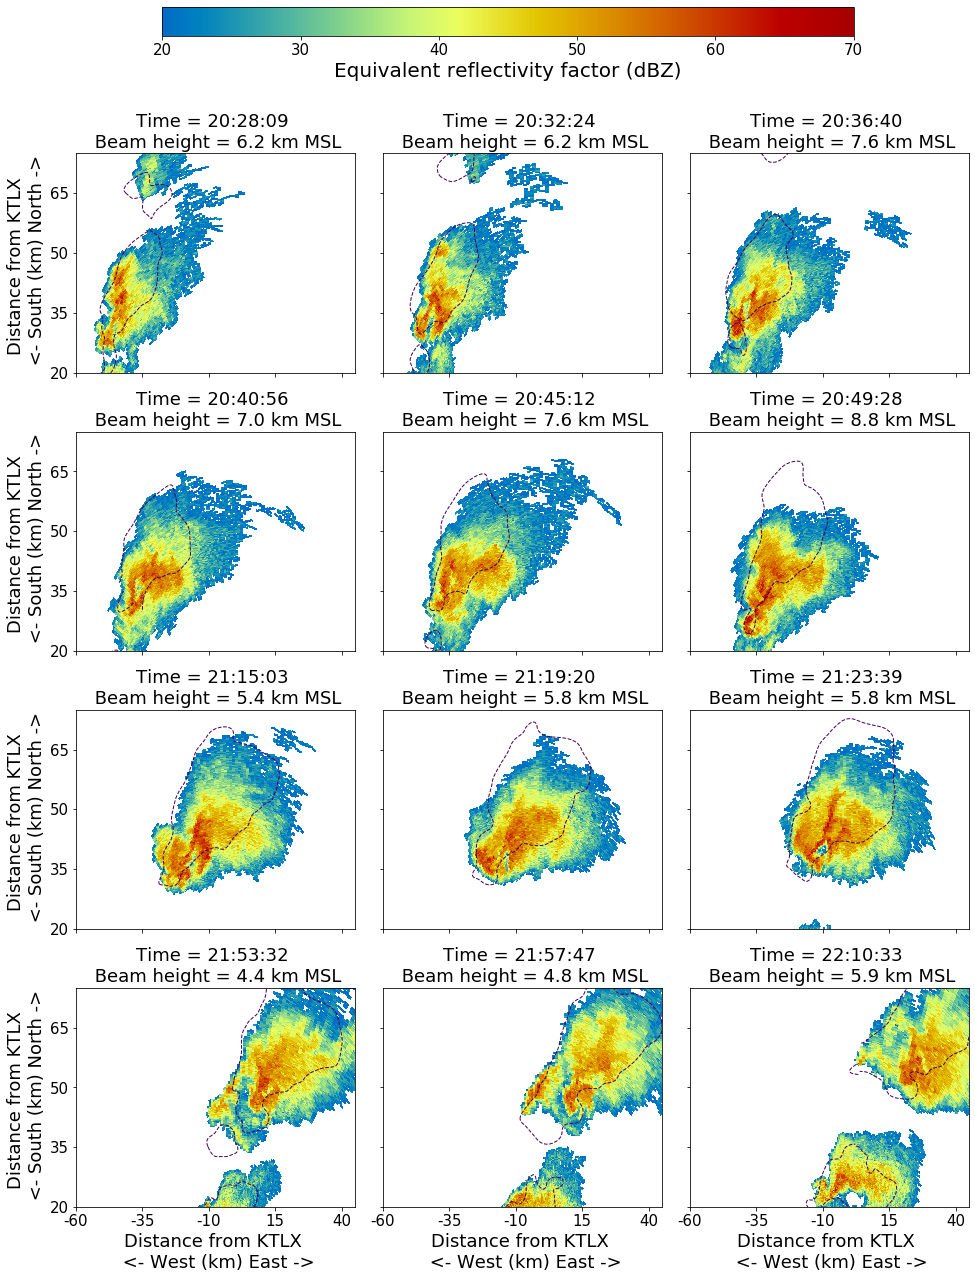

In [38]:
# panel plot for radar reflectivity at mid-levels (shaded) and low-level reflectivity (30 dBZ contour)

all_radars_new = np.reshape(all_radars, (4, 3))
llvl_swp = 0
widths = [15, 15, 15]
heights = [10, 10, 10, 10]

fig = plt.figure(constrained_layout=False, figsize=(16, 20))
spec2 = gridspec.GridSpec(
    ncols=3, nrows=4, figure=fig, width_ratios=widths, height_ratios=heights
)
spec2.update(wspace=0.1, hspace=0.1)


for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(spec2[row, col])
        display = pyart.graph.RadarDisplay(all_radars_new[row, col])
        p = display.plot_ppi(
                            "corrected_reflectivity",
                            mdlvl_swps[row, col],
                            vmin=20,
                            vmax=70,
                            cmap="pyart_HomeyerRainbow",
                            title_flag=False,
                            colorbar_flag=False,
                            colorbar_orient="horizontal",
                            axislabels_flag=False,
                            ax = ax,
                            fig = fig
                        )

        llvl_data = all_radars_new[row, col].get_field(
            llvl_swp, "corrected_reflectivity"
        )
        x, y, z = all_radars_new[row, col].get_gate_x_y_z(llvl_swp, edges=False)

        x /= 1000.0
        y /= 1000.0
        z /= 1000.0

        # apply a gaussian blur to the data set for nice smooth lines:
        # sigma adjusts the distance effect of blending each cell,
        # 4 is arbirarly set for visual impact.
        smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)

        # add contours
        levels = [30]

        # adds contours to plot
        contours = ax.contour(
            x, y, smooth_data, levels, linewidths=1, antialiased=True, linestyles="--"
        )

        ratio = 1.5
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)

        ax.set_xlim(-60, 45)
        ax.set_xticks([-60, -35, -10, 15, 40])
        ax.set_xticklabels(["-60", "-35", "-10", "15", "40"])

        ax.set_ylim(20, 75)
        ax.set_yticks([20, 35, 50, 65])
        ax.set_yticklabels(["20", "35", "50", "65"])
        
        if col in [1,2] and row in [0,1,2]:
            ax.set_xticklabels(labels=[])
            ax.set_yticklabels(labels=[])
            
        if row in [0,1,2]:
            ax.set_xticklabels(labels=[])
#             ax.set_yticklabels(labels=[])
        
        if col in [1,2]:
            ax.set_yticklabels(labels=[])

        title = datetime.strftime(
            datetime.strptime(
                all_radars_new[row, col]
                .time["units"]
                .split("/")[-1]
                .split(".")[0]
                .split(" ")[-1],
                "%Y-%m-%dT%H:%M:%SZ",
            ),
            "%H:%M:%S",
        )
#         ax.set_title(f"Time = {title}",fontsize=18)
        ax.set_title(f"Time = {title} \n Beam height = {round(int(np.reshape(bm_hghts,(4,3))[row,col])/1000,1)} km MSL",fontsize=18)

        if col == 0:
            ax.set_ylabel("Distance from KTLX \n <- South (km) North ->",fontsize=18)
        if row == 3:
            ax.set_xlabel("Distance from KTLX \n <- West (km) East ->",fontsize=18)

cbaxes = fig.add_axes([0.2,0.95,0.6,0.02])
display.plot_colorbar(cax=cbaxes,orient='horizontal')

cbaxes.axes.set_xlabel('Equivalent reflectivity factor (dBZ)',fontsize=20)

plt.tight_layout()
plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/Zcontourslowmidlevels_new.png',dpi=300)
plt.show()


/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/io/cfradial.py:365: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


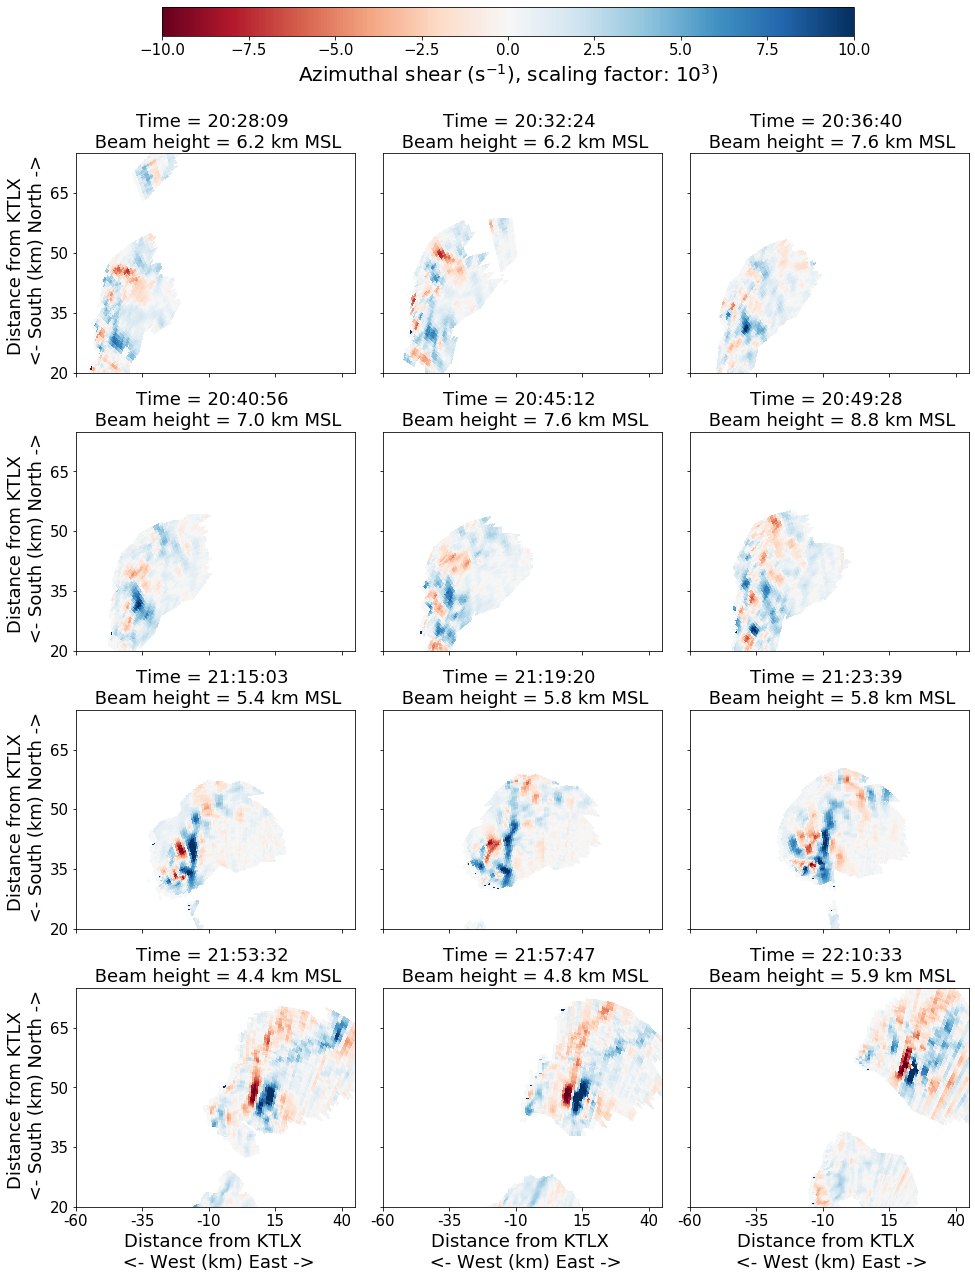

In [39]:
all_azshear_radars = []

for i in range(len(files_az_shear_interest)):
    radar = pyart.io.read(files_az_shear_interest[i])
    all_azshear_radars.append(radar)
    
# panel plot for radar reflectivity at mid-levels (shaded) and low-level reflectivity (30 dBZ contour)

all_radars_new = np.reshape(all_azshear_radars, (4, 3))
llvl_swp = 0
widths = [15, 15, 15]
heights = [10, 10, 10, 10]

fig = plt.figure(constrained_layout=False, figsize=(16, 20))
spec2 = gridspec.GridSpec(
    ncols=3, nrows=4, figure=fig, width_ratios=widths, height_ratios=heights
)
spec2.update(wspace=0.1, hspace=0.1)


for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(spec2[row, col])
        display = pyart.graph.RadarDisplay(all_radars_new[row, col])
        p = display.plot_ppi(
                            "azi_shear",
                            mdlvl_swps[row, col],
                            vmin=-10,
                            vmax=10,
                            cmap=cm.RdBu,
                            title_flag=False,
                            colorbar_flag=False,
                            colorbar_orient="horizontal",
                            axislabels_flag=False,
                            ax = ax,
                            fig = fig
                        )

#         llvl_data = all_radars_new[row, col].get_field(
#             llvl_swp, "corrected_reflectivity"
#         )
#         x, y, z = all_radars_new[row, col].get_gate_x_y_z(llvl_swp, edges=False)

#         x /= 1000.0
#         y /= 1000.0
#         z /= 1000.0

#         # apply a gaussian blur to the data set for nice smooth lines:
#         # sigma adjusts the distance effect of blending each cell,
#         # 4 is arbirarly set for visual impact.
#         smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)

#         # add contours
#         levels = [30]

#         # adds contours to plot
#         contours = ax.contour(
#             x, y, smooth_data, levels, linewidths=1, antialiased=True, linestyles="--"
#         )

        ratio = 1.5
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright - xleft) / (ybottom - ytop)) * ratio)

        ax.set_xlim(-60, 45)
        ax.set_xticks([-60, -35, -10, 15, 40])
        ax.set_xticklabels(["-60", "-35", "-10", "15", "40"])

        ax.set_ylim(20, 75)
        ax.set_yticks([20, 35, 50, 65])
        ax.set_yticklabels(["20", "35", "50", "65"])
        
        if col in [1,2] and row in [0,1,2]:
            ax.set_xticklabels(labels=[])
            ax.set_yticklabels(labels=[])
            
        if row in [0,1,2]:
            ax.set_xticklabels(labels=[])
#             ax.set_yticklabels(labels=[])
        
        if col in [1,2]:
            ax.set_yticklabels(labels=[])

        title = datetime.strftime(
            datetime.strptime(
                all_radars_new[row, col]
                .time["units"]
                .split("/")[-1]
                .split(".")[0]
                .split(" ")[-1],
                "%Y-%m-%dT%H:%M:%SZ",
            ),
            "%H:%M:%S",
        )
        ax.set_title(f"Time = {title} \n Beam height = {round(int(np.reshape(bm_hghts,(4,3))[row,col])/1000,1)} km MSL",fontsize=18)

        if col == 0:
            ax.set_ylabel("Distance from KTLX \n <- South (km) North ->",fontsize=18)
        if row == 3:
            ax.set_xlabel("Distance from KTLX \n <- West (km) East ->",fontsize=18)

cbaxes = fig.add_axes([0.2,0.95,0.6,0.02])
display.plot_colorbar(cax=cbaxes,orient='horizontal')

cbaxes.axes.set_xlabel('Azimuthal shear (s$^{-1}$), scaling factor: 10$^{3}$)',fontsize=20)

plt.tight_layout()
plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/az_shear.png',dpi=300)
plt.show()


In [ ]:
/Users/ms/Desktop/mount/May_19_2013_all_stuff/